# What's next after ARI clustering probe?


ARI have been run to find the best leiden resolution for the data, now we must transfer this obs and obsm columns to our orginial adata and reorganize cluster labels by % of prediction ('top3_labels_per_cluster.csv').

In [9]:
import scanpy as sc, json
import pandas as pd 
import numpy as np 

In [1]:


OUT = "/home/mdiaz/HCC_project/hcc_adata"
ad  = sc.read_h5ad(f"{OUT}/adata_with_scvi_best.h5ad")

# 1) Leer mejor configuración y confirmar n_clusters
best = json.load(open(f"{OUT}/best_config.json"))
print(best)
print("n_clusters:", ad.obs["leiden_best"].nunique())

{'metric': 'cosine', 'k': 10, 'resolution': 0.2, 'ARI': 0.48376104023915745, 'silhouette_euclid_on_scVI': 0.1375591903924942, 'n_clusters': 18, 'key': 'leiden_cosine_10_0.2'}
n_clusters: 18


In [2]:
# 2) UMAP en X_scVI y guardar PNG
if "X_umap" not in ad.obsm:
    sc.pp.neighbors(ad, use_rep="X_scVI", n_neighbors=int(best["k"]), metric=best["metric"])
    sc.tl.umap(ad, min_dist=0.4, spread=1.0)
sc.pl.umap(ad, color=["leiden_best", "predicted"], wspace=0.4, save="_best_vs_pred.png", show=False)

[<Axes: title={'center': 'leiden_best'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'predicted'}, xlabel='UMAP1', ylabel='UMAP2'>]

In [3]:
# 3) Top etiquetas por cluster (para diagnóstico rápido)
ct = pd.crosstab(ad.obs["leiden_best"], ad.obs["predicted"])
top = (ct.div(ct.sum(1), axis=0).stack()
         .groupby(level=0).nlargest(3).to_frame("prop"))
top.to_csv(f"{OUT}/top3_labels_per_cluster.csv")

/tmp/ipykernel_3984749/3288520017.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top = (ct.div(ct.sum(1), axis=0).stack()


In [4]:
# Paths (edit)
SRC = "/home/mdiaz/HCC_project/hcc_adata/adata_with_scvi_best.h5ad"   
DST = "/home/mdiaz/HCC_project/hcc_adata/1_5T_unintegrated_CellTypeFromPred.h5ad"  
OUT = "/home/mdiaz/HCC_project/hcc_adata/1_5T_unintegrated_bestClustering.h5ad"

# Load
ad_src = sc.read_h5ad(SRC)   # has 'leiden_best' and X_scVI
ad_dst = sc.read_h5ad(DST)   # your working AnnData

# 1) Align by cell barcodes
# Keep target order; select only cells present in both
common = ad_dst.obs_names[ad_dst.obs_names.isin(ad_src.obs_names)]
if common.size == 0:
    raise ValueError("No overlapping cells between source and destination AnnData.")

coverage = common.size / ad_dst.n_obs
print(f"Coverage on destination: {coverage:.1%} ({common.size}/{ad_dst.n_obs})")


Coverage on destination: 100.0% (40771/40771)


In [5]:
# 2) Transfer obs columns
cols_to_copy = ["leiden_best"]  # add more if you need specific partitions
for col in cols_to_copy:
    if col not in ad_src.obs.columns:
        print(f"Warning: '{col}' not in source; skipping.")
        continue
    ad_dst.obs.loc[common, col] = ad_src.obs.loc[common, col].astype("category")


In [10]:
# 3) Transfer colors in .uns (optional but useful for plotting)
for key in ["leiden_best_colors", "predicted_colors"]:
    if key in ad_src.uns:
        ad_dst.uns[key] = ad_src.uns[key]

# 4) Transfer scVI latent to .obsm (recommended)
if "X_scVI" in ad_src.obsm:
    n_lat = ad_src.obsm["X_scVI"].shape[1]
    # Prepare a full matrix (NaNs for cells not in 'common')
    X = np.full((ad_dst.n_obs, n_lat), np.nan, dtype=np.float32)
    # Build indexers for fast aligned assignment
    src_pos = pd.Index(ad_src.obs_names).get_indexer(common)
    dst_pos = pd.Index(ad_dst.obs_names).get_indexer(common)
    X[dst_pos, :] = ad_src.obsm["X_scVI"][src_pos, :]
    ad_dst.obsm["X_scVI"] = X
else:
    print("Warning: 'X_scVI' missing in source; skipping latent transfer.")


In [11]:
# 5) (Optional) Recompute neighbors/UMAP on destination using the transferred X_scVI
#    Only if you want UMAP consistent with the best k/metric you chose.
sc.pp.neighbors(ad_dst, use_rep="X_scVI", n_neighbors=10, metric="cosine")
sc.tl.umap(ad_dst)

# 6) Save a new file to avoid overwriting your base object
ad_dst.write(OUT, compression="gzip")
print("Saved:", OUT)

2025-09-22 13:12:36.890899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-22 13:12:36.992943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-22 13:12:37.022549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 13:12:37.192443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 13:12:41.167216: W tensorflow/comp

Saved: /home/mdiaz/HCC_project/hcc_adata/1_5T_unintegrated_bestClustering.h5ad


# Relabeling 

In [12]:
adata = sc.read_h5ad('/home/mdiaz/HCC_project/hcc_adata/1_5T_unintegrated_bestClustering.h5ad')

In [13]:
corrected_cell_labels={"0":"TAM",
"1":"T cells",
"2":"TEC",
"3":"Malignant",
"4":"Neutrophil",
"5":"TAM",
"6":"NK-TR-CD160",
"7":"Malignant",
"8":"B cells",
"9":"cDCs",
"10":"B cells",
"11":"Neutrophil",
"12":"CAF",
"13":"Hep",
"14":"B cells",
"15":"Basophil",
"16":"TEC",
"17":"Macrophage",
}

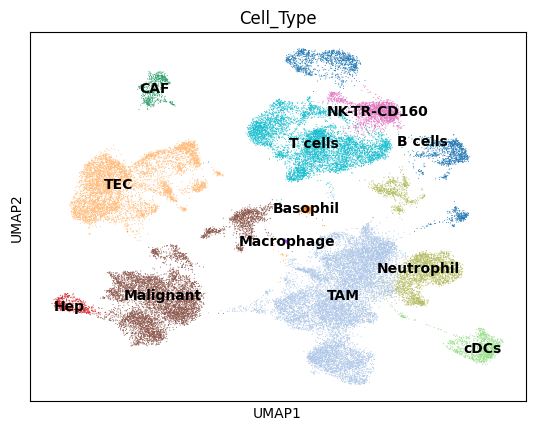

In [14]:
adata.obs['Cell_Type'] = adata.obs.leiden_best.map(corrected_cell_labels)
sc.pl.umap(adata, color=['Cell_Type'], s=2, legend_loc='on data')

# Verification WITH scANVI labeling

In [15]:
df = adata.obs[['CellType', 'transfer_score', 'leiden_best']].copy()

# Etiqueta mayoritaria por cluster (si hay empate, toma la primera moda)
labels = df.groupby('leiden_best')['CellType'].agg(
    lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]
)

# Promedio de transfer_score por cluster
scores = df.groupby('leiden_best')['transfer_score'].mean()

# Tabla final
mapping_res = pd.concat(
    [labels.rename('majority_celltype'),
     scores.rename('mean_transfer_score')],
    axis=1
).reset_index()

mapping_res.head(50)

/tmp/ipykernel_3984749/127687806.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels = df.groupby('leiden_best')['CellType'].agg(
/tmp/ipykernel_3984749/127687806.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scores = df.groupby('leiden_best')['transfer_score'].mean()


,leiden_best,majority_celltype,mean_transfer_score
0,0,TAM,0.895413
1,1,T cells,0.864879
2,2,TEC,0.908876
3,3,tumor,0.919494
4,4,neutrophil,0.903003
5,5,TAMs,0.877203
6,6,NK-CD160-tissue resident,0.931027
7,7,Malignant cells,0.854687
8,8,B cells,0.965454
9,9,conventional dendritic cell,0.916931


In [18]:
adata.write_h5ad('/home/mdiaz/HCC_project/hcc_adata/2T_unintegrated_bestClustering.h5ad')